# 군집분석 : 타깃마케팅을 위한 K-평균 군집화

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive') 

### 1) 데이터 수집

In [ ]:
import pandas as pd
import math

In [ ]:
retail_df = pd.read_excel('./Online_Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2) 데이터 준비 및 탐색

In [ ]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# 오류 데이터 정제
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]

# 'CustomerID' 자료형을 정수형으로 변환
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [ ]:
retail_df.info()
print(retail_df.isnull().sum())
print(retail_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int32         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 25.8+ MB
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
(397884, 8)


In [ ]:
# 중복 레코드 제거
retail_df.drop_duplicates(inplace=True)

print(retail_df.shape) #작업 확인용 출력

(392692, 8)


#### - 제품 수, 거래건 수, 고객 수 탐색

In [ ]:
pd.DataFrame([{'Product':len(retail_df['StockCode'].value_counts()),
              'Transaction':len(retail_df['InvoiceNo'].value_counts()),
              'Customer':len(retail_df['CustomerID'].value_counts())}],
             columns = ['Product', 'Transaction', 'Customer'],
            index = ['counts'])

,Product,Transaction,Customer
counts,3665,18532,4338


In [ ]:
retail_df['Country'].value_counts()

United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [ ]:
# 주문금액 컬럼 추가
retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']

retail_df.head() #작업 확인용 출력

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### - 고객의 마지막 주문후 경과일(Elapsed Days), 주문횟수(Freq), 주문 총액(Total Amount) 구하기

In [ ]:
#마케팅에 이용하기 위해 고객의 주문 횟수, 주문 총액, 그리고 마지막 주문 후 며칠이 지났는지에 대한 정보를 추출

aggregations = {
 'InvoiceNo':'count',
 'SaleAmount':'sum',
 'InvoiceDate':'max'
}

customer_df = retail_df.groupby('CustomerID').agg(aggregations) #CustomerID 기준으로 그룹화
customer_df = customer_df.reset_index()
customer_df.head()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


In [ ]:
#마케팅에 이용하기 위해 고객의 주문 횟수, 주문 총액, 그리고 마지막 주문 후 며칠이 지났는지에 대한 정보를 추출

customer_df = customer_df.rename(columns = {'InvoiceNo':'Freq', 'InvoiceDate':'ElapsedDays'}) # 컬럼 이름 변경
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


#### - 마지막 구매후 경과일 계산하기

In [ ]:
#마지막 주문일로부터 며칠이 지났는지에 대한 값을 ElapsedDays 컬럼에 저장
#    ‘기준 날짜 - 마지막 구매일’로 계산해 구함(날짜기준: 2011년 12월 10일)

import datetime

customer_df['ElapsedDays'] = datetime.datetime(2011,12,10) - customer_df['ElapsedDays']
customer_df.head() 

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,325 days 13:59:00
1,12347,182,4310.00,2 days 08:08:00
2,12348,31,1797.24,75 days 10:47:00
3,12349,73,1757.55,18 days 14:09:00
4,12350,17,334.40,310 days 07:59:00


In [ ]:
# 날짜수로 환산
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x: x.days+1)
customer_df.head() 

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,326
1,12347,182,4310.00,3
2,12348,31,1797.24,76
3,12349,73,1757.55,19
4,12350,17,334.40,311


#### - 현재 데이터 값의 분포 확인하기

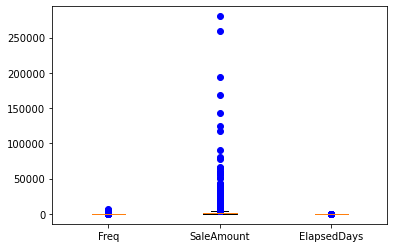

In [ ]:
import matplotlib.pyplot as plt
import seaborn as 눈

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym = 'bo')
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount','ElapsedDays'])
plt.show()


#### - 데이터 값의 왜곡(치우침)을 줄이기 위한 작업 : 로그 함수로 분포 조정

In [ ]:
# 컬럼 값에 로그 함수를 취한 값을 새 컬럼으로 추가하여 저장

import numpy as np

customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])
customer_df.head() 

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,326,0.693147,11.253955,5.789960
1,12347,182,4310.00,3,5.209486,8.368925,1.386294
2,12348,31,1797.24,76,3.465736,7.494564,4.343805
3,12349,73,1757.55,19,4.304065,7.472245,2.995732
4,12350,17,334.40,311,2.890372,5.815324,5.743003


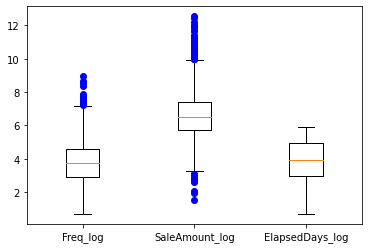

In [ ]:
# 박스플롯 그리기
fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'], customer_df['ElapsedDays_log']], sym = 'bo')
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])
plt.show()

### 3) 모델 구축 : K-평균 군집화 모델

In [ ]:
# K-평균 군집화 모델링을 위한 KMeans와 
# 실루엣 계수 계산에 사용할 라이브러리 임포트
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
# K-평균 모델에 사용할 값을 X_features에 저장
X_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values

In [ ]:
# X_features를 정규 분포로 스케일링StandardScaler( ).fit_transform하여 X_features_ scaled에 저장
from sklearn.preprocessing import StandardScaler 
X_features_scaled = StandardScaler().fit_transform(X_features)

### - 최적의 k 찾기 (1) 엘보우 방법

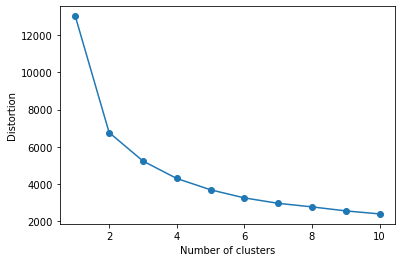

In [ ]:
#엘보 방법으로 클러스터 개수 k 선택하기
# 클러스터 개수가 1~10일 때 왜곡 값의 변화를 시각화
distortions = []

for i in range(1, 11):
    kmeans_i = KMeans(n_clusters = i, random_state = 0) #모델 생성
    kmeans_i.fit(X_features_scaled)                                #모델 훈련
    distortions.append(kmeans_i.inertia_)

plt.plot(range(1,11), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


In [ ]:
# 클러스터의 개수 k를 3으로 설정하여 K-평균 모델을 다시 구축한 뒤 모델에서 만든 클러스터 레이블을 확인

kmeans = KMeans(n_clusters=3, random_state=0) #모델 생성
#모델 학습과 결과 예측(클러스터 레이블 생성)
Y_labels = kmeans.fit_predict(X_features_scaled)

In [ ]:
customer_df['ClusterLabel'] = Y_labels
customer_df.head()                                         

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,2
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,2
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,2
4,12350,17,334.40,311,2.890372,5.815324,5.743003,0


## 4) 결과 분석 및 시각화

### - 최적의 k 찾기 (2) 실루엣 계수에 따른 각 클러스터의 비중 시각화 함수 정의

In [ ]:
# 실루엣 계수를 구하고, 각 클러스터의 비중을 가로 바 차트barh( )로 시각화하기 위해 silhouetteViz 함수를 정의
from matplotlib import cm


def silhouetteViz(n_cluster, X_features):
    kmeans = KMeans(n_clusters = n_cluster, random_state = 0)
    Y_labels = kmeans.fit_predict(X_features)

    silhouette_values = silhouette_samples(X_features, Y_labels, metric = 'euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes, height = 1.0, edgecolor = 'none', color = color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)

    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
    plt.title('Number of Cluster : '+ str(n_cluster) + '\n' + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()


### - 클러스터 수에 따른 클러스터 데이터 분포의 시각화 함수 정의

In [ ]:
# 클러스터의 데이터 분포를 확인하기 위해 스캐터 차트로 시각화
#클러스터에 대한 데이터의 분포를 스캐터 차트scatter( )로 시각화하기 위해 cluster Scatter 함수를 정의

def clusterScatter(n_cluster, X_features):
    c_colors = []
    kmeans = KMeans(n_clusters = n_cluster, random_state = 0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) #클러스터의 색상 설정
        c_colors.append(c_color)
#클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1], marker = 'o', color =  c_color, edgecolor = 'black', s = 50, label = 'cluster '+ str(i))

#각 클러스터의 중심점을 삼각형으로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], marker = '^', color = c_colors[i], edgecolor = 'w', s = 200)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


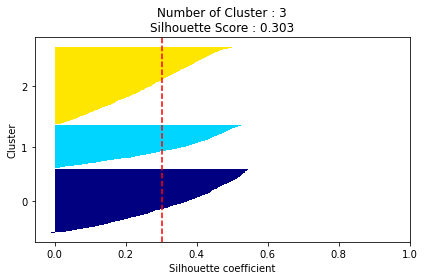

In [ ]:
silhouetteViz(3, X_features_scaled)

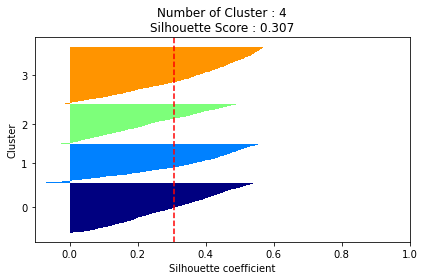

In [ ]:
silhouetteViz(4, X_features_scaled)

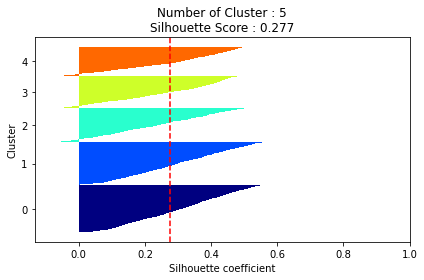

In [ ]:
silhouetteViz(5, X_features_scaled)

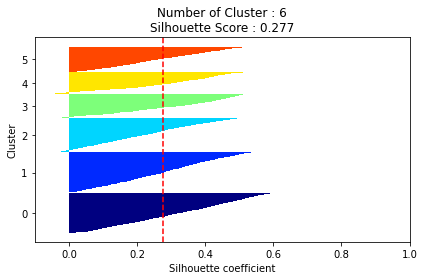

In [ ]:
silhouetteViz(6, X_features_scaled)

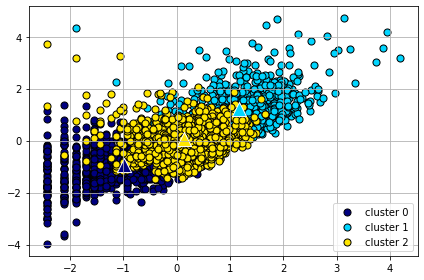

In [ ]:
clusterScatter(3, X_features_scaled)

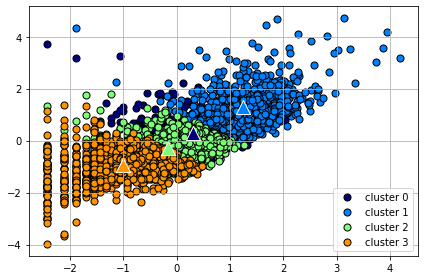

In [ ]:
clusterScatter(4, X_features_scaled)

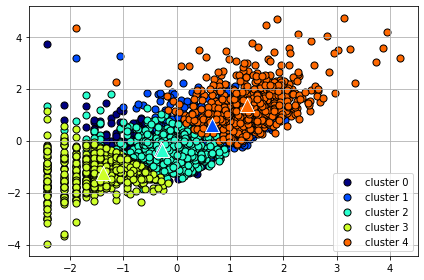

In [ ]:
clusterScatter(5, X_features_scaled)

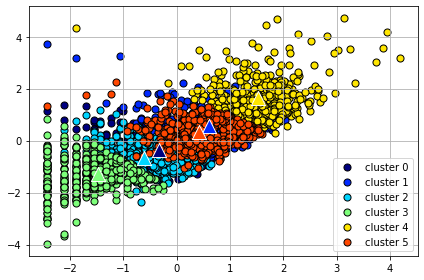

In [ ]:
clusterScatter(6, X_features_scaled)

### 결정된 k를 적용하여 최적의 K-mans 모델 완성

In [ ]:
best_cluster = 4
kmeans = KMeans(n_clusters = best_cluster, random_state = 0)
Y_labels = kmeans.fit_predict(X_features_scaled)


In [ ]:
customer_df['ClusterLabel'] = Y_labels
customer_df.head()


,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,0
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,0
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,1
4,12350,17,334.40,311,2.890372,5.815324,5.743003,3


#### - ClusterLabel이 추가된 데이터를 파일로 저장

In [ ]:
customer_df.to_csv('./Online_Retail_Customer_Cluster.csv') 

## << 클러스터 분석하기 >>

### 1) 각 클러스터의 고객수

In [ ]:
customer_df.groupby('ClusterLabel')['CustomerID'].count()


ClusterLabel
0    1167
1     900
2     931
3    1340
Name: CustomerID, dtype: int64

클러스터의 특징을 살펴보기 위해 ClusterLabel을 기준으로 그룹을 만들었다.

전체 고객은 4,338명이며 클러스터 0은 1,167명이고 클러스터 1은 900명, 클러스터 2는931명, 클러스터 3은 1,340명으로 구성되어 있다. 

### 2) 각 클러스터의 특징

In [ ]:
customer_cluster_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'],axis = 1, inplace = False)

In [ ]:
#주문 1회당 평균 구매금액: SaleAmountAvg
customer_cluster_df['SaleAmountAvg'] = customer_cluster_df['SaleAmount']/customer_cluster_df['Freq']
customer_cluster_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,ClusterLabel,SaleAmountAvg
0,12346,1,77183.60,326,0,77183.600000
1,12347,182,4310.00,3,1,23.681319
2,12348,31,1797.24,76,0,57.975484
3,12349,73,1757.55,19,1,24.076027
4,12350,17,334.40,311,3,19.670588


In [ ]:
customer_cluster_df.drop(['CustomerID'],axis = 1, inplace = False).groupby('ClusterLabel').mean()

,Freq,SaleAmount,ElapsedDays,SaleAmountAvg
ClusterLabel,,,,
0,74.443873,1453.809907,106.652956,106.760512
1,275.008889,6901.516111,14.833333,94.322099
2,41.978518,643.460173,20.473684,31.243547
3,14.347761,283.721501,184.191791,43.337452


클러스터 0의 경우 주문 횟수는 74건이고, 주문금액은 1453으로 비교적 높은 편에 속한다. 마지막 주문으로부터 약 106일이 경과했으며, 주문 1회당 평균 구매금액은 약 106으로 가장 높다.

클러스터 1의 경우 주문 횟수는 275건으로 가장 높으며, 주문금액은 6901로 가장 높다. 마지막 주문으로부터 경과된 시간이 14일로 가장 짧으며, 주문 1회당 평균 구매금액은 약 94이다.

클러스터 2의 경우 주문횟수는 41건이며, 주문금액은 643이다. 마지막 주문으로부터 경과일수는 20으로 비교적 짧으며, 주문 1회당 평균 구매금액은 약 31로 가장 적다.

클러스터 3의 경우 주문 횟수는 14건으로 가장 적고, 구매금액은 283으로 가장 낮다. 마지막 주문으로부터 경과일수가 184일로 가장 길며, 주문 1회당 평균 구매금액은 약 43으로 비교적 적은 편에 속한다.

클러스터 1은 주문 횟수가 많고 주문 간격(마지막 구매 후 경과일)이 짧으며 주문 금액도 비교적 높은 편에 속하므로 활발한 구매자 그룹이며 고가 제품을 선호한다고 해석할 수 있다. 
따라서 멤버십 서비스나 고가 제품에 대한 혜택이나 프로모션을 제공하여 구매를 유도하는 전략을 고려해볼 수 있다.

클러스터 0과 2는 주문 횟수가 중간 정도에 속하지만 평균 주문금액은 클러스터 0이 더 높고 주문 간격은 클러스터 2가 더 짧다.
이러한 차이를 고려하여 클러스터 0에게는 고가 제품에 대한 혜택과 할인 등을 제공하여 재구매율을 높이고, 클러스터 2에게는 정기 구독 서비스나 세트 할인 등을 제공하여 구매금액을 늘리는 전략을 고려해볼 수 있다.

클러스터 3은 주문 횟수와 주문금액이 낮은 편에 속하고 주문 간격이 긴 편이므로, 고객을 유지하고 재구매율을 높이기 위한 개인화된 서비스나 특별 혜택을 제공하는 전략을 고려해볼 수 있다.